# Magics

In [1]:
%load_ext autoreload

%autoreload 2

# Imports

In [2]:
import os
import gc
import configparser
import pathlib as p
import numpy as np
import seaborn as sns

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt 

In [4]:
import pandas as pd
pd.options.display.max_columns = 999

In [5]:
import torch

In [6]:
import clipper_python as clipper

In [7]:
import torch.nn as nn
import torch.optim as optim

In [8]:
from frag_nn.pytorch.network import GNINA_regressor_v5, GNINA_regressor_v6, GNINA_regressor_v7, GNINA_regressor_v8, GNINA_regressor_v9, GNINA_regressor_v10
from frag_nn.pytorch.network import ClassifierV3
from frag_nn.data import XChemData
from frag_nn.pytorch.dataset import EventDataset
from frag_nn.pytorch.dataset import OrthogonalGrid
from frag_nn.pytorch.dataset import GetRandomisedLocation, GetRandomisedRotation
from frag_nn.pytorch.dataset import GetAnnotationClassifier, GetDataRefMove, GetDataRefMoveZ


import frag_nn.constants as c


In [9]:
# Args

In [10]:
config_path = "/dls/science/groups/i04-1/conor_dev/pandda_nn/frag_nn/params.ini"

In [11]:
grid_size = 48
grid_step = 0.5

# Get Config

In [12]:
conf = configparser.ConfigParser()

In [13]:
conf.read(config_path)

['/dls/science/groups/i04-1/conor_dev/pandda_nn/frag_nn/params.ini']

In [14]:
ds_conf = conf[c.x_chem_database]

In [15]:

network_type = "classifier"
network_version = 3
dataset_version = 3

# Load Database

In [16]:
events_train = pd.read_csv("new_events_train.csv")

/dls/science/groups/i04-1/conor_dev/anaconda/envs/env_pytorch/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [17]:
events_test = pd.read_csv("new_events_test.csv")

# Create Dataset

In [18]:
grid= OrthogonalGrid(grid_size, 
                     grid_step)

In [19]:
dataset_train = EventDataset(events=events_train,
                             transforms_record=[GetRandomisedLocation(base_trans_max=0.0, secondary_trans_max=0.0),
                                                    GetRandomisedRotation(max_rot=0.0)],
                             get_annotation=GetAnnotationClassifier(),
                             get_data=GetDataRefMoveZ(grid)
                            )

In [20]:
len(dataset_train)

20972

In [29]:
sample = dataset_train[np.random.randint(len(dataset_train))]

In [30]:
# sample = dataset_train[300]

In [31]:
x = sample["data"]

In [32]:
sample["annotation"]

array([1., 0.], dtype=float32)

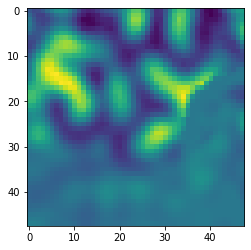

In [33]:
# Plot 
x_np_slice_2d_ref = x[0, :, :, int(x.shape[2]/2)]
plt.imshow(x_np_slice_2d_ref)

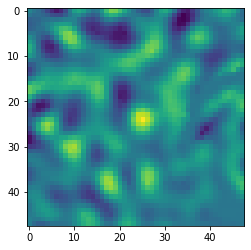

In [34]:
x_np_slice_2d_z = x[1, :, :, int(x.shape[2]/2)]
plt.imshow(x_np_slice_2d_z)

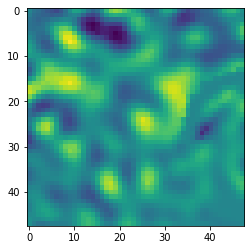

In [35]:
x_np_slice_2d_event = x[2, :, :, int(x.shape[2]/2)]
plt.imshow(x_np_slice_2d_event)

In [36]:
sample["record"].location()

KeyError: 'record'

In [ ]:
sample["record"].rotation()

In [ ]:
sample["record"].ground_map_path()

In [ ]:
sample["record"].z_map_path()

In [ ]:
sample["record"].event_map_path()

In [ ]:
x.std()

# Create Dataloader

In [ ]:
train_dataloader = torch.utils.data.DataLoader(dataset_train,
                                         batch_size=10, 
                                         shuffle=True,
                                         num_workers=10)

# Define Model

In [ ]:
model = ClassifierV3(32,
                        grid_dimension=grid_size)

In [ ]:
"model_params_{}_{}_{}_{}_{}.pt".format(grid_size,
                                                             grid_step,
                                                                           network_type,
                                                                    network_version,
                                                                       dataset_version)

In [ ]:
model.load_state_dict(torch.load("model_params_{}_{}_{}_{}_{}.pt".format(grid_size,
                                                             grid_step,
                                                                           network_type,
                                                                    network_version,
                                                                       dataset_version)))

In [ ]:
print(model)

# Define loss function

In [ ]:
# criterion = nn.MSELoss()
criterion = nn.BCELoss()

# Define optimizer

In [ ]:
optimizer = optim.Adam(model.parameters(), 
                       lr=0.0001)


# Fit Model

In [ ]:
num_epochs = 500

In [ ]:
running_loss = 0

In [ ]:
for epoch in range(num_epochs):
    for i, data in enumerate(train_dataloader):
        # get the inputs; data is a list of [inputs, labels]
        x = data["data"]
        y = data["annotation"]
        y = y.view(-1,2)
#         y = y + 1
#         print("meanx")
#         print(x.mean())
#         print(x.shape)
#         print(y.shape)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(x)
#         print(outputs)
#         print(outputs)
        loss = criterion(outputs, y)
#         print(loss)
        loss.backward()
        optimizer.step()
        
        # RECORD LOSS
        running_loss += loss.item()
#         print("Iteration number: {}, loss: {}".format(i, loss.item()))
#         print("{}".format([round(float(x), 3) for x in outputs]))
#         print("{}".format([round(float(x), 3) for x in y]))
#         print("{}".format([x for x in outputs]))
#         print("{}".format([x for x in y]))



        # print statistics per epoch
        if i % 30 == 29:    # print every 100 mini-batches
            print("Loss at epoch {}, iteration {} is {}".format(epoch,
                                                                 i,
                                                                 running_loss / i))
            print("{}".format([x for x in outputs]))
            print("{}".format([x for x in y]))
            print("#################################################")
    print("###################################")
#         print('[%d, %5d] loss: %.3f' %
#               (epoch + 1, i + 1, running_loss / 20))
    print("Loss for epoch {}: {}".format(epoch, running_loss))
    print(outputs)
    print(y)
    print(loss)
    running_loss = 0.0
            
    torch.save(model.state_dict(), "model_params_{}_{}_{}_{}_{}.pt".format(grid_size,
                                                             grid_step,
                                                                           network_type,
                                                                    network_version,
                                                                       dataset_version))

In [ ]:
torch.save(model.state_dict(), "model_params_{}_{}_{}_{}_{}.pt".format(grid_size,
                                                             grid_step,
                                                                           network_type,
                                                                    network_version,
                                                                       dataset_version))

In [ ]:
model(x)

In [ ]:
y